In [1]:
import cudf
import matplotlib.pyplot as plt
print(cudf.__version__)
import numpy as np
import cupy as cp
import pandas as pd
from tqdm import tqdm

23.04.01


In [2]:
chunk_size = 100000

chunks = []
panda1_path = '/workspaces/wiggle-face/data/panda_data/panda_new/keypoints_clean_PANDA1_2_dataset.csv'
panda3_path = '/workspaces/wiggle-face/data/panda_data/panda_new/keypoints_clean_PANDA3_2_dataset.csv'

# read the CSV file in chunks (run for all 3 datasets)
for chunk in pd.read_csv(panda1_path, chunksize=chunk_size):
    # pandas DataFrame chunk to cuDF DataFrame
    cudf_chunk = cudf.DataFrame.from_pandas(chunk)
    chunks.append(cudf_chunk)

# concatenate
df = cudf.concat(chunks, ignore_index=True)

print(df.head())

   infant_id        date  cam  frame_id  keypoint_index  \
0          3  2021_07_21    3         0              34   
1          3  2021_07_21    3         0              35   
2          3  2021_07_21    3         0              36   
3          3  2021_07_21    3         0              37   
4          3  2021_07_21    3         0              38   

                                   keypoint  keypoint_score   face_part  
0      (1027.427734375, 229.10992431640625)        0.751885  Right_brow  
1   (1039.9215087890625, 220.3180389404297)        0.762259  Right_brow  
2  (1055.6544189453125, 218.92984008789062)        0.720471  Right_brow  
3  (1070.9244384765625, 221.24349975585938)        0.673808  Right_brow  
4  (1086.6573486328125, 224.94534301757812)        0.599189  Right_brow  


In [3]:
# split the keypoint column into 2 columns for the x and y coordinates
df[['x_coordinate', 'y_coordinate']] = df['keypoint'].str.extract(r'\(([^,]+), ([^,]+)\)').astype(np.float64)
df = df.drop(columns=['keypoint'])
df = df.sort_values(by=['infant_id', 'frame_id', 'keypoint_index']).reset_index(drop=True)
    
print(df.head(319))

     infant_id        date  cam  frame_id  keypoint_index  keypoint_score  \
0            3  2021_07_21    3         0              34        0.751885   
1            3  2021_07_21    3         0              35        0.762259   
2            3  2021_07_21    3         0              36        0.720471   
3            3  2021_07_21    3         0              37        0.673808   
4            3  2021_07_21    3         0              38        0.599189   
..         ...         ...  ...       ...             ...             ...   
314          3  2021_07_21    3         5              48        0.895803   
315          3  2021_07_21    3         5              49        0.869897   
316          3  2021_07_21    3         5              50        0.833611   
317          3  2021_07_21    3         5              51        0.811244   
318          3  2021_07_21    3         5              52        0.889690   

      face_part  x_coordinate  y_coordinate  
0    Right_brow   1027.427734

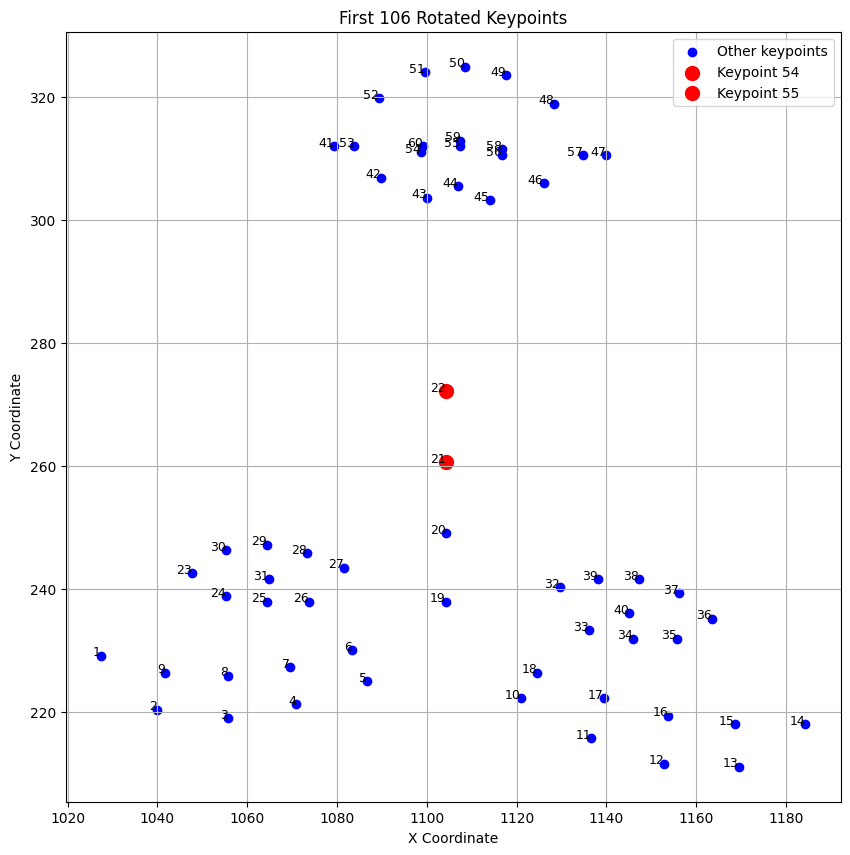

In [4]:
# figure
plt.figure(figsize=(10, 10))
x_coords = df['x_coordinate'][:60].values
y_coords = df['y_coordinate'][:60].values

x_coords = np.array(x_coords.get())
y_coords = np.array(y_coords.get())

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_54_index = 20 
kp_55_index = 21

plt.scatter(x_coords[kp_54_index], y_coords[kp_54_index], c='red', marker='o', label='Keypoint 54', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(60):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')
plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
def move_and_rotate_keypoints_updated(df):
    def get_rotation_matrix(angle):
        return np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ])

    def rotate_points(points, angle):
        rotation_matrix = get_rotation_matrix(angle)
        return np.dot(points, rotation_matrix.T)

    def normalize_points(points):
        min_vals = points.min(axis=0)
        max_vals = points.max(axis=0)
        scale = max(max_vals - min_vals)
        normalized_points = 2 * ((points - min_vals) / scale) - 1
        return normalized_points

    def sum_abs_x(angle):
        rotated = rotate_points(translated_coords_np, angle)
        return np.sum(np.abs(rotated[:, 0]))
        
    result = []

    # keypoint indexes to be aligned
    align_keypoints = [52, 53, 54, 55, 88, 94]

    grouped = df.groupby(['infant_id', 'frame_id'])
    
    for (infant_id, frame_id), group in tqdm(grouped, desc="Processing frames"):
        kp_54 = cp.array(group[group['keypoint_index'] == 55][['x_coordinate', 'y_coordinate']].values[0])
        
        # coordinates of the keypoints to be aligned
        keypoints_to_align = cp.array(group[group['keypoint_index'].isin(align_keypoints)][['x_coordinate', 'y_coordinate']].values)
        translated_coords = keypoints_to_align - kp_54
        translated_coords_np = translated_coords.get()
        
        # optimal angle to minimize the sum of absolute x-coordinates
        angles = np.linspace(-np.pi, np.pi, 360)
        optimal_angle = angles[np.argmin([sum_abs_x(a) for a in angles])]
        
        # translate all keypoints relative to kp_54
        all_translated_coords = cp.array(group[['x_coordinate', 'y_coordinate']].values) - kp_54
    
        all_translated_coords_np = all_translated_coords.get()
        rotated_coords = rotate_points(all_translated_coords_np, optimal_angle)
        normalized_coords = normalize_points(rotated_coords)
 
        kp_54_index = group['keypoint_index'].values == 55
        normalized_coords -= normalized_coords[kp_54_index.get()].reshape(1, -1)
        
        kp_52_y = normalized_coords[group['keypoint_index'].values.get() == 52][0, 1]
        
        if kp_52_y < 0:
            normalized_coords = rotate_points(normalized_coords, np.pi)

        transformed_group = group.copy()
        transformed_group[['x_coordinate', 'y_coordinate']] = normalized_coords
        
        result.append(transformed_group.to_pandas())
    
    return pd.concat(result).reset_index(drop=True)

transformed_df = move_and_rotate_keypoints_updated(cudf.DataFrame(df))
print(transformed_df)

Processing frames: 0it [00:00, ?it/s]

Processing frames: 84729it [14:43, 99.40it/s] 

: 

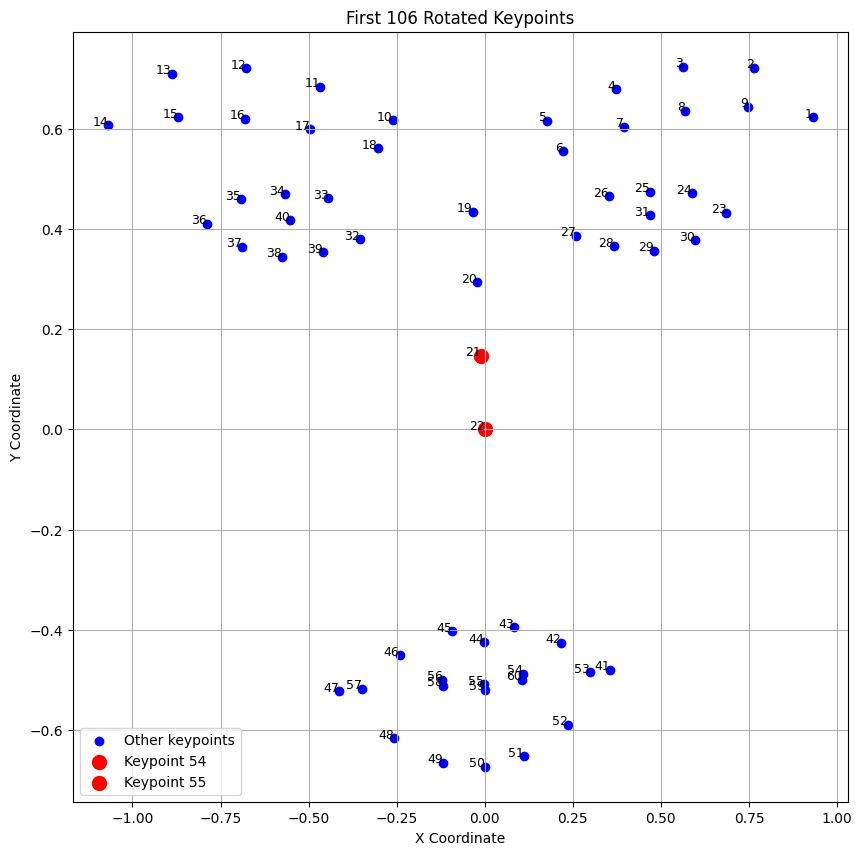

In [ ]:
# figure
plt.figure(figsize=(10, 10))

x_coords = transformed_df['x_coordinate'][:60].values
y_coords = transformed_df['y_coordinate'][:60].values

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_54_index = 20  
kp_55_index = 21  

plt.scatter(x_coords[kp_54_index], y_coords[kp_54_index], c='red', marker='o', label='Keypoint 54', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(60):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')

plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#df.drop(['processed_keypoint'], axis=1, inplace=True)
#transformed_df.drop(['processed_keypoint'], axis=1, inplace=True)


In [8]:
df.head(10)

,infant_id,date,cam,frame_id,keypoint_index,keypoint_score,face_part,x_coordinate,y_coordinate
0,3,2021_07_21,3,0,34,0.751885,Right_brow,1027.427734,229.109924
1,3,2021_07_21,3,0,35,0.762259,Right_brow,1039.921509,220.318039
2,3,2021_07_21,3,0,36,0.720471,Right_brow,1055.654419,218.929840
3,3,2021_07_21,3,0,37,0.673808,Right_brow,1070.924438,221.243500
4,3,2021_07_21,3,0,38,0.599189,Right_brow,1086.657349,224.945343
5,3,2021_07_21,3,0,39,0.787136,Right_brow,1083.418213,230.035385
6,3,2021_07_21,3,0,40,0.828133,Right_brow,1069.536255,227.259003
7,3,2021_07_21,3,0,41,0.865623,Right_brow,1055.654419,225.870804
8,3,2021_07_21,3,0,42,0.882729,Right_brow,1041.772461,226.333542
9,3,2021_07_21,3,0,43,0.580880,Left_brow,1120.899536,222.168961


In [21]:
transformed_df.head(10)

,infant_id,date,cam,frame_id,keypoint_index,keypoint_score,face_part,x_coordinate,y_coordinate
0,3,18829,3,0,34,0.751885,Right_brow,0.930848,0.622487
1,3,18829,3,0,35,0.762259,Right_brow,0.763644,0.721456
2,3,18829,3,0,36,0.720471,Right_brow,0.562779,0.723314
3,3,18829,3,0,37,0.673808,Right_brow,0.371487,0.678700
4,3,18829,3,0,38,0.599189,Right_brow,0.175715,0.616021
5,3,18829,3,0,39,0.787136,Right_brow,0.221877,0.554727
6,3,18829,3,0,40,0.828133,Right_brow,0.395107,0.603819
7,3,18829,3,0,41,0.865623,Right_brow,0.569724,0.635310
8,3,18829,3,0,42,0.882729,Right_brow,0.746195,0.643334
9,3,18829,3,0,43,0.580880,Left_brow,-0.261216,0.616959


In [20]:
df = transformed_df.copy()

In [ ]:
df.to_csv('keypoints_clean_PANDA1_2_dataset_rotated.csv', index=False)
print("Dataset saved successfully as keypoints_clean_PANDA1_2_dataset_rotated.csv")

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y_%m_%d')
df['date'] = (df['date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

cp_df = {
    'infant_id': cp.array(df['infant_id'].values),
    'date': cp.array(df['date'].values),
    'cam': cp.array(df['cam'].values),
    'frame_id': cp.array(df['frame_id'].values),
    'keypoint_index': cp.array(df['keypoint_index'].values),
    'x_coordinate': cp.array(df['x_coordinate'].values),  # Adding x_coordinate for width and distance calculations
    'y_coordinate': cp.array(df['y_coordinate'].values)
}

# Define keypoints and their ranges
left_brow_indices = cp.array(range(34, 43))
right_brow_indices = cp.array(range(43, 52))
keypoint_pairs = {
    'right_eye': [(79, 81), (78, 82), (77, 83)],
    'left_eye': [(70, 72), (69, 73), (68, 74)],
    'lips': [(100, 102), (99, 103), (98, 104)]
}

indices_dict = {
    'upper_right_brow': cp.array(range(43, 48)),
    'lower_right_brow': cp.array(range(48, 52)),
    'upper_left_brow': cp.array(range(34, 39)),
    'lower_left_brow': cp.array(range(39, 43)),
    'upper_left_eyelid': cp.array(range(67, 72)),
    'lower_left_eyelid': cp.array(range(72, 75)),
    'upper_right_eyelid': cp.array(range(76, 81)),
    'lower_right_eyelid': cp.array(range(81, 84)),
    'upper_outer_lip': cp.array(range(85, 92)),
    'lower_outer_lip': cp.array(range(92, 98)),
    'upper_inner_lip': cp.array(range(98, 102)),
    'lower_inner_lip': cp.array(range(102, 105))
}

# Function to calculate mean y-coordinate for a set of keypoints
def mean_y_coordinate(indices, mask):
    return cp.mean(cp_df['y_coordinate'][mask & cp.isin(cp_df['keypoint_index'], indices)])

# Function to calculate mean distance between pairs of keypoints
def mean_distance(pairs, mask):
    distances = []
    for (p1, p2) in pairs:
        mask1 = mask & (cp_df['keypoint_index'] == p1)
        mask2 = mask & (cp_df['keypoint_index'] == p2)
        if cp.any(mask1) and cp.any(mask2):
            distances.append(cp.abs(cp.mean(cp_df['y_coordinate'][mask1]) - cp.mean(cp_df['y_coordinate'][mask2])))
    return cp.mean(cp.array(distances))

# Function for difference in x-coordinates
def diff_x_coordinates(idx1, idx2, mask):
    x1 = cp.mean(cp_df['x_coordinate'][mask & (cp_df['keypoint_index'] == idx1)])
    x2 = cp.mean(cp_df['x_coordinate'][mask & (cp_df['keypoint_index'] == idx2)])
    return cp.abs(x1 - x2)

# Function for Euclidean distance
def euclidean_distance(idx1, idx2, mask):
    x1 = cp.mean(cp_df['x_coordinate'][mask & (cp_df['keypoint_index'] == idx1)])
    y1 = cp.mean(cp_df['y_coordinate'][mask & (cp_df['keypoint_index'] == idx1)])
    x2 = cp.mean(cp_df['x_coordinate'][mask & (cp_df['keypoint_index'] == idx2)])
    y2 = cp.mean(cp_df['y_coordinate'][mask & (cp_df['keypoint_index'] == idx2)])
    return cp.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calculate_curvature_cp(x_coords, y_coords, mask):
    x_coords_filtered = x_coords[mask]
    y_coords_filtered = y_coords[mask]
    
    if len(x_coords_filtered) < 3 or len(y_coords_filtered) < 3:
        return cp.nan  # Need at least 3 points to calculate second derivative
    
    y_second_derivative = cp.gradient(cp.gradient(y_coords_filtered, x_coords_filtered), x_coords_filtered)
    curvature = cp.mean(y_second_derivative)
    
    return curvature

# Iterate through each unique video
results = []
for (infant_id, date, cam, frame_id), group in df.groupby(['infant_id', 'date', 'cam', 'frame_id']):
    mask = (cp_df['infant_id'] == infant_id) & (cp_df['date'] == date) & (cp_df['cam'] == cam) & (cp_df['frame_id'] == frame_id)
    curvatures = {f'curvature_{key}': calculate_curvature_cp(cp_df['x_coordinate'], cp_df['y_coordinate'], mask & cp.isin(cp_df['keypoint_index'], indices)).get() for key, indices in indices_dict.items()}
    # Additional features calculation using the previously defined functions
    features = {
        'right_brow_mean_y': mean_y_coordinate(right_brow_indices, mask).get(),
        'left_brow_mean_y': mean_y_coordinate(left_brow_indices, mask).get(),
        'right_eye_distance': mean_distance(keypoint_pairs['right_eye'], mask).get(),
        'left_eye_distance': mean_distance(keypoint_pairs['left_eye'], mask).get(),
        'lips_distance': mean_distance(keypoint_pairs['lips'], mask).get(),
        'left_eye_width': diff_x_coordinates(67, 71, mask).get(),
        'right_eye_width': diff_x_coordinates(76, 80, mask).get(),
        'left_eyebrow_width': diff_x_coordinates(34, 39, mask).get(),
        'right_eyebrow_width': diff_x_coordinates(47, 51, mask).get(),
        'lip_width': diff_x_coordinates(85, 91, mask).get(),
        'left_eye_upper_corner_left_eyebrow_center_dist': euclidean_distance(67, 41, mask).get(),
        'right_eye_upper_corner_and_right_eyebrow_center_dist': euclidean_distance(80, 49, mask).get(),
        'nose_centre_lips_centre_dist': diff_x_coordinates(55, 99, mask).get(),
        'left_eye_lower_corner_lips_left_corner_dist': euclidean_distance(85, 71, mask).get(),
        'right_eye_lower_corner_lips_right_corner_dist': euclidean_distance(76, 91, mask).get(),
        'left_eye_upper_corner_lips_left_corner_dist': euclidean_distance(85, 67, mask).get(),
        'right_eye_upper_corner_lips_right_corner_dist': euclidean_distance(80, 91, mask).get(),
        **curvatures
    }

    results.append({
        'infant_id': infant_id,
        'date': date,
        'cam': cam,
        'frame_id': frame_id,
        **features
    })

results_df = pd.DataFrame(results)
print(results_df)

: 

In [27]:
df['date'] = pd.to_datetime(df['date'], format='%Y_%m_%d')
df['date'] = (df['date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

cp_df = {
    'infant_id': cp.array(df['infant_id'].values),
    'date': cp.array(df['date'].values),
    'cam': cp.array(df['cam'].values),
    'frame_id': cp.array(df['frame_id'].values),
    'keypoint_index': cp.array(df['keypoint_index'].values),
    'y_coordinate': cp.array(df['y_coordinate'].values)
}

# Define keypoints
left_brow_indices = cp.array(range(34, 43))
right_brow_indices = cp.array(range(43, 52))
keypoint_pairs = {
    'right_eye': [(79, 81), (78, 82), (77, 83)],
    'left_eye': [(70, 72), (69, 73), (68, 74)],
    'lips': [(100, 102), (99, 103), (98, 104)]
}

# Function to calculate mean y-coordinate for a set of keypoints
def mean_y_coordinate(indices, mask):
    return cp.mean(cp_df['y_coordinate'][mask & cp.isin(cp_df['keypoint_index'], indices)])

# Function to calculate mean distance between pairs of keypoints
def mean_distance(pairs, mask):
    distances = []
    for (p1, p2) in pairs:
        mask1 = mask & (cp_df['keypoint_index'] == p1)
        mask2 = mask & (cp_df['keypoint_index'] == p2)
        if cp.any(mask1) and cp.any(mask2):
            distances.append(cp.abs(cp.mean(cp_df['y_coordinate'][mask1]) - cp.mean(cp_df['y_coordinate'][mask2])))
    return cp.mean(cp.array(distances))

# Aggregate results
results = []

# Group by 'infant_id', 'date', and 'cam'
for (infant_id, date, cam), group in df.groupby(['infant_id', 'date', 'cam']):
    mask = (cp_df['infant_id'] == infant_id) & (cp_df['date'] == date) & (cp_df['cam'] == cam)
    
    # Calculate metrics
    right_brow_mean_y = mean_y_coordinate(right_brow_indices, mask)
    left_brow_mean_y = mean_y_coordinate(left_brow_indices, mask)
    right_eye_distance = mean_distance(keypoint_pairs['right_eye'], mask)
    left_eye_distance = mean_distance(keypoint_pairs['left_eye'], mask)
    lips_distance = mean_distance(keypoint_pairs['lips'], mask)
    
    # Append results
    results.append({
        'infant_id': infant_id,
        'date': date,
        'cam': cam,
        'right_brow_mean_y': right_brow_mean_y.get(),
        'left_brow_mean_y': left_brow_mean_y.get(),
        'right_eye_distance': right_eye_distance.get(),
        'left_eye_distance': left_eye_distance.get(),
        'lips_distance': lips_distance.get()
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

: 

In [15]:


# new dataframe with unique infant_id and frame_id combinations
face_feature_df = df[['infant_id','date', 'cam' ,'frame_id']].drop_duplicates().reset_index(drop=True) #panda 1 and panda 3

# Keypoint indices for the left and right eyebrows
left_brow_indices = cp.array(list(range(34, 43)))
right_brow_indices = cp.array(list(range(43, 52)))
lip_pairs = [(100, 102), (99, 103), (98, 104)]
right_eye_pairs = [(79, 81), (78, 82), (77, 83)]
left_eye_pairs = [(70, 72), (69, 73), (68, 74)]

# DataFrame columns to CuPy arrays for keypoints
infant_ids = cp.array(df['infant_id'].values)
frame_ids = cp.array(df['frame_id'].values)
dates = cp.array(df['date_numeric'].values)
cams = cp.array(df['cam'].values)
keypoint_indices = cp.array(df['keypoint_index'].values)
y_coords = cp.array(df['y_coordinate'].values)

# Function to calculate the mean y-coordinate for specified keypoints
def calculate_mean_y_coord_cp(infant_ids, dates, cams, frame_ids, keypoint_indices, y_coords, infant_id, date, cam, frame_id, brow_indices):
    mask = (infant_ids == infant_id) & (dates == date) & (cams == cam) & (frame_ids == frame_id) & (cp.isin(keypoint_indices, brow_indices))
    return y_coords[mask].mean()

# Function to calculate the mean distance between specified keypoints
def calculate_mean_distance_cp(infant_ids, dates, cams, frame_ids, keypoint_indices, y_coords, infant_id, date, cam, frame_id, points):
    distances = []
    for p1, p2 in points:
        mask1 = (infant_ids == infant_id) & (dates == date) & (cams == cam) & (frame_ids == frame_id) & (keypoint_indices == p1)
        mask2 = (infant_ids == infant_id) & (dates == date) & (cams == cam) & (frame_ids == frame_id) & (keypoint_indices == p2)
        kp1 = y_coords[mask1]
        kp2 = y_coords[mask2]
        if kp1.size > 0 and kp2.size > 0:
            distance = cp.abs(kp1 - kp2)
            distances.append(distance)
    return cp.mean(cp.array(distances)) if distances else cp.nan

In [16]:
face_feature_df

,infant_id,date,cam,frame_id
0,3,2021-07-21,3,0
1,3,2021-07-21,3,1
2,3,2021-07-21,3,2
3,3,2021-07-21,3,3
4,3,2021-07-21,3,4
...,...,...,...,...
104036,83,2024-04-10,3,6883
104037,83,2024-04-10,3,6884
104038,83,2024-04-10,3,6885
104039,83,2024-04-10,3,6886


In [17]:
face_feature_df['date_numeric'] = (pd.to_datetime(face_feature_df['date'], format='%Y_%m_%d') - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

mean_y_coord_left_brow = []
mean_y_coord_right_brow = []

# function to process each row
def process_row(row):
    infant_id = row['infant_id']
    frame_id = row['frame_id']
    date_numeric = row['date_numeric']
    cam_numeric = row['cam']
    
    mean_y_left = calculate_mean_y_coord_cp(infant_ids, dates, cams, frame_ids, keypoint_indices, y_coords, infant_id, date_numeric, cam_numeric, frame_id, left_brow_indices).get()
    mean_y_right = calculate_mean_y_coord_cp(infant_ids, dates, cams, frame_ids, keypoint_indices, y_coords, infant_id, date_numeric, cam_numeric, frame_id, right_brow_indices).get()
    
    return mean_y_left, mean_y_right

results = []
for _, row in tqdm(face_feature_df.iterrows(), total=face_feature_df.shape[0], desc='Calculating mean y-coordinates for eyebrows'):
    results.append(process_row(row))

# split the results into separate lists
mean_y_coord_left_brow, mean_y_coord_right_brow = zip(*results)

# Add the results back to the dataframe
face_feature_df['mean_y_coord_left_brow'] = mean_y_coord_left_brow
face_feature_df['mean_y_coord_right_brow'] = mean_y_coord_right_brow

print(face_feature_df)

Calculating mean y-coordinates for eyebrows:   0%|          | 0/104041 [00:00<?, ?it/s]

Calculating mean y-coordinates for eyebrows: 100%|██████████| 104041/104041 [07:32<00:00, 230.00it/s]

        infant_id       date  cam  frame_id  date_numeric  \
0               3 2021-07-21    3         0         18829   
1               3 2021-07-21    3         1         18829   
2               3 2021-07-21    3         2         18829   
3               3 2021-07-21    3         3         18829   
4               3 2021-07-21    3         4         18829   
...           ...        ...  ...       ...           ...   
104036         83 2024-04-10    3      6883         19823   
104037         83 2024-04-10    3      6884         19823   
104038         83 2024-04-10    3      6885         19823   
104039         83 2024-04-10    3      6886         19823   
104040         83 2024-04-10    3      6887         19823   

       mean_y_coord_left_brow mean_y_coord_right_brow  
0          0.6443520477436713      0.6373308996666162  
1          0.6462558493160486       0.650785733581642  
2          0.6459183943638589      0.6533120864921428  
3          0.6485383038468744      0.658933

In [18]:
# Precompute static values
face_feature_df['date_numeric'] = (pd.to_datetime(face_feature_df['date'], format='%Y_%m_%d') - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

# Prepare lists to store the results
right_eye_eyelid_distance = []
left_eye_eyelid_distance = []
lip_distance = []

# Function to process each row
def process_row(row):
    infant_id = row['infant_id']
    frame_id = row['frame_id']
    date_numeric = row['date_numeric']
    cam_numeric = row['cam']
    
    right_eye_dist = calculate_mean_distance_cp(infant_ids, dates, cams, frame_ids, keypoint_indices, y_coords, infant_id, date_numeric, cam_numeric, frame_id, right_eye_pairs).get()
    left_eye_dist = calculate_mean_distance_cp(infant_ids, dates, cams, frame_ids, keypoint_indices, y_coords, infant_id, date_numeric, cam_numeric, frame_id, left_eye_pairs).get()
    lip_dist = calculate_mean_distance_cp(infant_ids, dates, cams, frame_ids, keypoint_indices, y_coords, infant_id, date_numeric, cam_numeric, frame_id, lip_pairs).get()
    
    return right_eye_dist, left_eye_dist, lip_dist

# Apply the function to each row with tqdm progress tracking
results = []
for _, row in tqdm(face_feature_df.iterrows(), total=face_feature_df.shape[0], desc='Calculating distances for keypoints'):
    results.append(process_row(row))

# Split the results into separate lists
right_eye_eyelid_distance, left_eye_eyelid_distance, lip_distance = zip(*results)

# Add the results back to the dataframe
face_feature_df['right_eye_eyelid_distance'] = right_eye_eyelid_distance
face_feature_df['left_eye_eyelid_distance'] = left_eye_eyelid_distance
face_feature_df['lip_distance'] = lip_distance

print(face_feature_df)

Calculating distances for keypoints:   0%|          | 0/104041 [00:00<?, ?it/s]

Calculating distances for keypoints:  17%|█▋        | 17744/104041 [11:14<54:38, 26.33it/s]  


KeyboardInterrupt: 

In [15]:
face_feature_df.head()

,infant_id,date,cam,frame_id,date_numeric,mean_y_coord_left_brow,mean_y_coord_right_brow,right_eye_eyelid_distance,left_eye_eyelid_distance,lip_distance
0,201,2021-11-11,3,1,18942,0.4068848215338077,0.46912032266177284,0.0800055183204819,0.09096771220769033,0.060471466906650694
1,201,2021-11-11,3,2,18942,0.8774778528756814,0.9319020912964577,0.07720645126182483,0.0882181635465525,0.06549074159244676
2,201,2021-11-11,3,3,18942,0.43042457689673597,0.47481296098765413,0.07592475195341497,0.08549827041926276,0.05744130261696997
3,201,2021-11-11,3,4,18942,0.42229460497620946,0.4655447782384493,0.08082057715593301,0.08872255600661087,0.06546029493341694
4,201,2021-11-11,3,5,18942,0.42151245728316816,0.4636924909340515,0.0837826550459942,0.0917765177591147,0.06046481717348092


In [16]:
# determine if the eyes and mouth are closed based on the distances
threshold_eyes = 0.035
threshold_mouth =  0.04 
face_feature_df['right_eye_closed'] = face_feature_df['right_eye_eyelid_distance'] < threshold_eyes
face_feature_df['left_eye_closed'] = face_feature_df['left_eye_eyelid_distance'] < threshold_eyes
face_feature_df['mouth_closed'] = face_feature_df['lip_distance'] < threshold_mouth

print(face_feature_df)

       infant_id       date  cam  frame_id  date_numeric  \
0            201 2021-11-11    3         1         18942   
1            201 2021-11-11    3         2         18942   
2            201 2021-11-11    3         3         18942   
3            201 2021-11-11    3         4         18942   
4            201 2021-11-11    3         5         18942   
...          ...        ...  ...       ...           ...   
58796        241 2024-05-16    3      6007         19859   
58797        241 2024-05-16    3      6008         19859   
58798        241 2024-05-16    3      6009         19859   
58799        241 2024-05-16    3      6010         19859   
58800        241 2024-05-16    3      6011         19859   

      mean_y_coord_left_brow mean_y_coord_right_brow  \
0         0.4068848215338077     0.46912032266177284   
1         0.8774778528756814      0.9319020912964577   
2        0.43042457689673597     0.47481296098765413   
3        0.42229460497620946      0.4655447782384493   

In [17]:
def calculate_curvature_cp(infant_ids, dates, cams, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, date, cam, frame_id, indices):
    # Create a mask to filter relevant coordinates
    mask = (infant_ids == infant_id) & (dates == date) & (cams == cam) & (frame_ids == frame_id) & cp.isin(keypoint_indices, indices)
    x_coords_filtered = x_coords[mask]
    y_coords_filtered = y_coords[mask]
    
    if len(x_coords_filtered) < 3 or len(y_coords_filtered) < 3:
        return cp.nan  # Need at least 3 points to calculate second derivative
    
    # Compute the second derivatives
    y_second_derivative = cp.gradient(cp.gradient(y_coords_filtered, x_coords_filtered), x_coords_filtered)
    # Compute the mean of the second derivatives
    curvature = cp.mean(y_second_derivative)
    
    return curvature

# Keypoint indices for the specified face parts
indices_dict = {
    'upper_right_brow': cp.array(list(range(43, 48))),
    'lower_right_brow': cp.array(list(range(48, 52))),
    'upper_left_brow': cp.array(list(range(34, 39))),
    'lower_left_brow': cp.array(list(range(39, 43))),
    'upper_left_eyelid': cp.array(list(range(67, 72))),
    'lower_left_eyelid': cp.array(list(range(72, 75))),
    'upper_right_eyelid': cp.array(list(range(76, 81))),
    'lower_right_eyelid': cp.array(list(range(81, 84))),
    'upper_outer_lip': cp.array(list(range(85, 92))),
    'lower_outer_lip': cp.array(list(range(92, 98))),
    'upper_inner_lip': cp.array(list(range(98, 102))),
    'lower_inner_lip': cp.array(list(range(102, 105)))
}

# DataFrame columns to CuPy arrays for keypoints
infant_ids = cp.array(df['infant_id'].values)
dates = cp.array((pd.to_datetime(df['date'], format='%Y_%m_%d') - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D'))
cams = cp.array(df['cam'].values)
frame_ids = cp.array(df['frame_id'].values)
keypoint_indices = cp.array(df['keypoint_index'].values)
x_coords = cp.array(df['x_coordinate'].values)
y_coords = cp.array(df['y_coordinate'].values)

# Initialize dictionaries to store curvature results
curvature_results = {key: [] for key in indices_dict.keys()}

for index in tqdm(range(len(face_feature_df)), desc='Calculating curvatures for specified face parts'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    date_numeric = (pd.to_datetime(face_feature_df['date'].iloc[index], format='%Y_%m_%d') - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')
    cam_numeric = face_feature_df['cam'].iloc[index]
    
    for part, indices in indices_dict.items():
        curvature = calculate_curvature_cp(infant_ids, dates, cams, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, date_numeric, cam_numeric, frame_id, indices).get()
        curvature_results[part].append(curvature)

Calculating curvatures for specified face parts: 100%|██████████| 58801/58801 [36:27<00:00, 26.88it/s]


In [18]:
# Add the curvature results back to the DataFrame using .loc to avoid setting on a copy warning
for part, curvatures in curvature_results.items():
    face_feature_df[f'curvature_{part}'] = curvatures

print(face_feature_df)

       infant_id       date  cam  frame_id  date_numeric  \
0            201 2021-11-11    3         1         18942   
1            201 2021-11-11    3         2         18942   
2            201 2021-11-11    3         3         18942   
3            201 2021-11-11    3         4         18942   
4            201 2021-11-11    3         5         18942   
...          ...        ...  ...       ...           ...   
58796        241 2024-05-16    3      6007         19859   
58797        241 2024-05-16    3      6008         19859   
58798        241 2024-05-16    3      6009         19859   
58799        241 2024-05-16    3      6010         19859   
58800        241 2024-05-16    3      6011         19859   

      mean_y_coord_left_brow mean_y_coord_right_brow  \
0         0.4068848215338077     0.46912032266177284   
1         0.8774778528756814      0.9319020912964577   
2        0.43042457689673597     0.47481296098765413   
3        0.42229460497620946      0.4655447782384493   

In [19]:
face_feature_df.head(10)

,infant_id,date,cam,frame_id,date_numeric,mean_y_coord_left_brow,mean_y_coord_right_brow,right_eye_eyelid_distance,left_eye_eyelid_distance,lip_distance,...,curvature_upper_left_brow,curvature_lower_left_brow,curvature_upper_left_eyelid,curvature_lower_left_eyelid,curvature_upper_right_eyelid,curvature_lower_right_eyelid,curvature_upper_outer_lip,curvature_lower_outer_lip,curvature_upper_inner_lip,curvature_lower_inner_lip
0,201,2021-11-11,3,1,18942,0.4068848215338077,0.46912032266177284,0.0800055183204819,0.09096771220769033,0.060471466906650694,...,-1.9163750773880792,-0.6416404343080624,-2.8182638037899137,1.5879495561860464,-2.8932078324884913,1.6924746458909607,-1.7524042839974854,6.542518444717833,-0.7574891517303037,0.7574841336803836
1,201,2021-11-11,3,2,18942,0.8774778528756814,0.9319020912964577,0.07720645126182483,0.0882181635465525,0.06549074159244676,...,-1.9798048120787441,-0.5122550173012368,-2.874284860548454,1.854991544936014,-2.9367473212123723,1.4675486768702817,-1.9838122706959578,7.9748383788841375,-0.723719224593641,1.016063084766853
2,201,2021-11-11,3,3,18942,0.43042457689673597,0.47481296098765413,0.07592475195341497,0.08549827041926276,0.05744130261696997,...,-2.291671669014163,-0.7437529904690927,-2.5300336825790177,1.6722685341694936,-2.6017473851421244,1.5931096502914823,-1.8689596538939734,8.161788707038303,-0.6240489907393667,0.8431122027951999
3,201,2021-11-11,3,4,18942,0.42229460497620946,0.4655447782384493,0.08082057715593301,0.08872255600661087,0.06546029493341694,...,-2.269600806951397,-0.5979893134487826,-2.7775407892252573,2.0440088248036212,-2.506553900365321,1.8451895061300128,-1.7695458314446089,9.70586186073753,-0.7919307474067372,0.8409048515337271
4,201,2021-11-11,3,5,18942,0.42151245728316816,0.4636924909340515,0.0837826550459942,0.0917765177591147,0.06046481717348092,...,-2.1385711858828076,-0.6749518603004505,-2.9456690895897766,1.9525038169026756,-2.5125142695478067,1.321036938743723,-1.8592618559526064,8.247430407807771,-0.7475713519090768,0.8743807369906812
5,201,2021-11-11,3,6,18942,0.4103109020509226,0.4437266876804732,0.08287213721469204,0.09044093853651021,0.0677346072536034,...,-1.9984038657011634,-0.579897120351772,-2.862563716083951,1.5964363720866512,-2.577822135180086,1.666559786791945,-1.9143015787394935,7.981623479253226,-0.809919924272243,0.8533079183439497
6,201,2021-11-11,3,7,18942,0.4155360787173586,0.45834221456838503,0.08301204984246453,0.0908047026391711,0.05875941508715236,...,-1.8995145302655352,-0.6661657659004406,-2.7977836839633126,1.9657063185296444,-2.7836544194435806,1.2803846735686537,-1.9485195708827128,7.044064384983087,-0.703439591059161,0.8550248157418876
7,201,2021-11-11,3,8,18942,0.42547077436263236,0.4593936822325314,0.08347039808533456,0.08945430119935834,0.06225309996770756,...,-2.046425508847861,-0.6671635969328179,-2.706792777432482,1.6593910339231108,-2.616284324739253,1.5255937680922596,-1.893288151301088,9.060463304807152,-0.6536380902603358,0.7089985134976503
8,201,2021-11-11,3,9,18942,0.9001443709519459,0.9379684221050968,0.08653329503606544,0.09263210619099486,0.05916528249842545,...,-2.1366982823840868,-0.7442870456084318,-3.0729772522890517,1.406240124976368,-2.6621291460487155,1.592205910863336,-1.9243067365779005,8.781356181036804,-0.7317020011950086,0.7107729643282058
9,201,2021-11-11,3,10,18942,0.8840261272062286,0.935391869003823,0.08339465113113982,0.09139028585651758,0.05945249505855902,...,-2.1164509468351884,-0.6788860270017024,-3.0711800386740054,1.5930122543782712,-2.427282826514513,1.2716983687015475,-1.9451910582485044,8.506848713227063,-0.6350801569625227,0.5544531231876867


In [20]:
# change the name panda1/panda3
face_feature_df.to_csv('face_features_with_curvatures_panda3.csv', index=False)

In [75]:
# function to calculate displacement manually
def calculate_manual_displacement(group):
    group['shifted_x'] = group['x_coordinate'].shift(1)
    group['shifted_y'] = group['y_coordinate'].shift(1)

    group['interframe_x_displacement'] = group['x_coordinate'] -  group['shifted_x']
    group['interframe_y_displacement'] =  group['y_coordinate'] - group['shifted_y']

    group['interframe_x_displacement'] = group['interframe_x_displacement'].fillna(0)
    group['interframe_y_displacement'] = group['interframe_y_displacement'].fillna(0)
    
    return group

# displacement for all keypoints
df = df.groupby(['infant_id','date' ,'cam', 'keypoint_index']).apply(calculate_manual_displacement).reset_index(drop=True)
df = df.drop(columns = ['shifted_x','shifted_y'])
df.loc[df['frame_id'] == 0, ['interframe_x_displacement', 'interframe_y_displacement']] = 0.0

print(df.head(1320))

/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/cudf/core/groupby/groupby.py:1169: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 6890 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


      infant_id  frame_id  keypoint_score face_part  keypoint_index  \
0             0         0        0.577999      Chin               1   
1             0         1        0.514304      Chin               1   
2             0         2        0.493515      Chin               1   
3             0         3        0.466503      Chin               1   
4             0         4        0.473813      Chin               1   
...         ...       ...             ...       ...             ...   
1315          0      1315        0.711513      Chin               1   
1316          0      1316        0.703581      Chin               1   
1317          0      1317        0.721716      Chin               1   
1318          0      1318        0.754950      Chin               1   
1319          0         0        0.752206      Chin               2   

      x_coordinate  y_coordinate  interframe_x_displacement  \
0       351.601135    463.115295                   0.000000   
1       349.961029   

In [77]:
mean_displacements = df.groupby(['infant_id','date', 'cam' ,'keypoint_index'])[['interframe_x_displacement', 'interframe_y_displacement']].mean().reset_index()
mean_displacements.rename(columns={
    'interframe_x_displacement': 'mean_x_displacement_keypoint',
    'interframe_y_displacement': 'mean_y_displacement_keypoint'
}, inplace=True)

# calculating the average confidence per keypoint per infant, based on keypoint_scores 
average_confidence = df.groupby(['infant_id','date', 'cam','keypoint_index'])['keypoint_score'].mean().reset_index()
average_confidence.rename(columns={'keypoint_score': 'average_confidence_keypoint'}, inplace=True)
face_parts = df[['infant_id','date', 'cam' ,'keypoint_index', 'face_part']].drop_duplicates()

# merge all metrics
metrics_df = cudf.merge(mean_displacements, average_confidence, on=['infant_id','date', 'cam', 'keypoint_index'])
metrics_df = cudf.merge(metrics_df, face_parts, on=['infant_id','date', 'cam','keypoint_index'])

metrics_df = metrics_df.sort_values(by=['infant_id','date', 'cam', 'keypoint_index'])
metrics_df = metrics_df.reset_index(drop=True)

print(metrics_df.head(107))

     infant_id  keypoint_index  mean_x_displacement_keypoint  \
0            0               1                     -0.108792   
1            0               2                     -0.104563   
2            0               3                     -0.100725   
3            0               4                     -0.097220   
4            0               5                     -0.093938   
..         ...             ...                           ...   
102          0             103                     -0.091342   
103          0             104                     -0.090394   
104          0             105                     -0.109413   
105          0             106                     -0.115715   
106          1               1                      0.000633   

     mean_y_displacement_keypoint  average_confidence_keypoint    face_part  
0                        0.010605                     0.495667         Chin  
1                        0.009601                     0.778484         Chin

In [76]:
# change the name panda1/panda3
df.to_csv('displacements_panda1.csv', index=False)

In [78]:
# change the name panda1/panda3
metrics_df.to_csv('keypoints_metrics_panda1.csv', index=False)